<h1 style="background-color:DodgerBlue;"> Anamoly detection ||  Outlier detection Libraries </h1>

## 🚨  **Scenario: E-commerce: Product Review Anomaly Detection **
- Goal: Detecting fraudulent or fake reviews is a challenge for e-commerce platforms.

**Description**:  
- **Rating**: The review rating (from 1 to 5 stars).
- **Review Text**: The content of the review (either positive or negative).
- **Review Timestamp**: The time when the review was posted.

### 🔍 **1. Get Review Data**

In [1]:
import pandas as pd
import numpy as np
from faker import Faker

# Set random seed
np.random.seed(42)
fake = Faker()

# Create synthetic dataset
num_samples = 1000
timestamps = pd.date_range(start="2023-01-01", periods=num_samples, freq="D")
ratings = np.random.choice([1, 2, 3, 4, 5], size=num_samples, p=[0.05, 0.1, 0.2, 0.3, 0.35])
review_lengths = np.random.normal(loc=200, scale=50, size=num_samples).astype(int)
sentiment_scores = np.clip(np.random.normal(loc=0.7, scale=0.2, size=num_samples), -1, 1)

# Inject anomalies (5%)
anomaly_indices = np.random.choice(num_samples, size=int(0.05 * num_samples), replace=False)
ratings[anomaly_indices] = np.random.choice([1, 5], size=len(anomaly_indices))
review_lengths[anomaly_indices] = np.random.randint(10, 50, size=len(anomaly_indices))
sentiment_scores[anomaly_indices] = np.random.uniform(-1, 0.1, size=len(anomaly_indices))

# Create DataFrame
df = pd.DataFrame({
    'timestamp': timestamps,
    'rating': ratings,
    'review_length': review_lengths,
    'sentiment_score': sentiment_scores,
    'is_anomaly': 0
})

df.loc[anomaly_indices, 'is_anomaly'] = 1
df.head()

,timestamp,rating,review_length,sentiment_score,is_anomaly
0,2023-01-01,4,208,0.418737,0
1,2023-01-02,5,133,0.683379,0
2,2023-01-03,5,219,0.399056,0
3,2023-01-04,4,230,0.852011,0
4,2023-01-05,3,227,0.716488,0


### 🧪 **2. Preprocess and Scale Features**

In [2]:

from sklearn.preprocessing import StandardScaler

# Features for detection
features = df[['rating', 'review_length', 'sentiment_score']]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

### 🧠 **3. Train PyOD Anomaly Detection Models**

In [3]:
from pyod.models.knn import KNN
knn_model = KNN()

In [4]:
from pyod.models.iforest import IForest
iforest_model = IForest()

In [5]:
from pyod.models.auto_encoder import AutoEncoder

# Initialize the AutoEncoder model
autoencoder_model = AutoEncoder()

In [6]:
# Fit models 

knn_model.fit(X_scaled)
iforest_model.fit(X_scaled)
autoencoder_model.fit(X_scaled)

Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]


### 🧾 **4. Evaluate with Ground Truth Labels**

In [7]:
from sklearn.metrics import classification_report

# Ground truth
y_true = df['is_anomaly']

# Model predictions
df['knn_anomaly'] = knn_model.labels_
df['iforest_anomaly'] = iforest_model.labels_
df['autoencoder_anomaly'] = autoencoder_model.labels_

# Reports
print("📌 KNN Results:")
print(classification_report(y_true, df['knn_anomaly']))

📌 KNN Results:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       950
           1       0.22      0.44      0.29        50

    accuracy                           0.89      1000
   macro avg       0.59      0.68      0.62      1000
weighted avg       0.93      0.89      0.91      1000



In [8]:
print("📌 Isolation Forest Results:")
print(classification_report(y_true, df['iforest_anomaly']))

📌 Isolation Forest Results:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       950
           1       0.50      1.00      0.67        50

    accuracy                           0.95      1000
   macro avg       0.75      0.97      0.82      1000
weighted avg       0.97      0.95      0.96      1000



In [9]:
print("📌 AutoEncoder Results:")
print(classification_report(y_true, df['autoencoder_anomaly']))

📌 AutoEncoder Results:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       950
           1       0.28      0.56      0.37        50

    accuracy                           0.91      1000
   macro avg       0.63      0.74      0.66      1000
weighted avg       0.94      0.91      0.92      1000




### 📈 **5. Visualize Anomalies Detected Over Time**

C:\Users\USER\AppData\Local\Temp\ipykernel_10772\188168930.py:19: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from current font.
  plt.tight_layout()
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


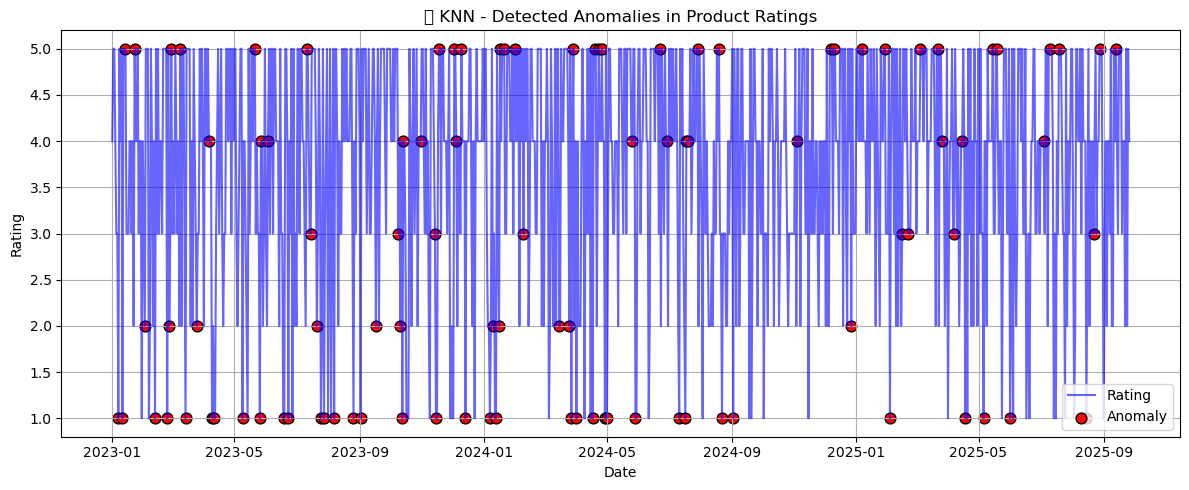

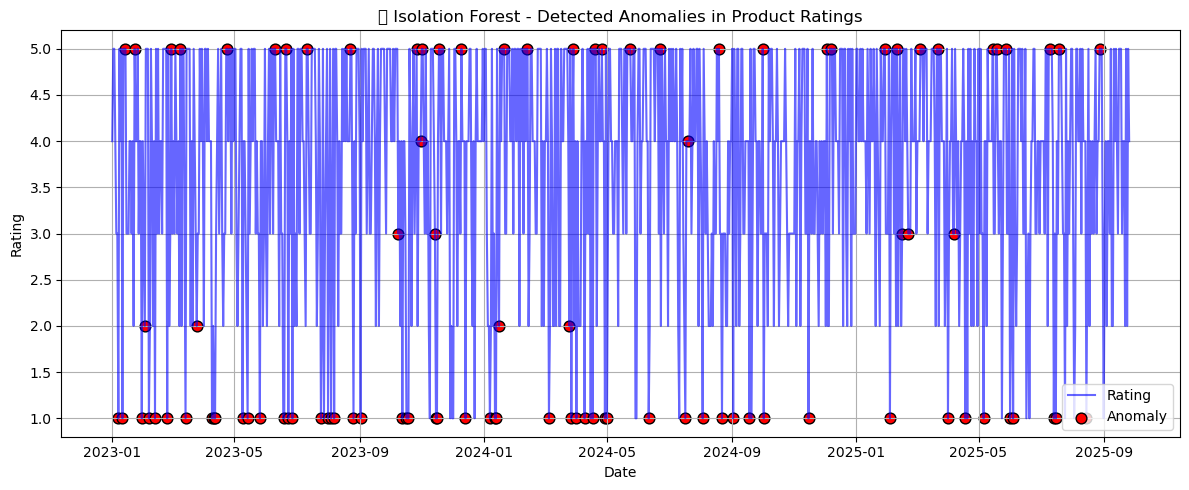

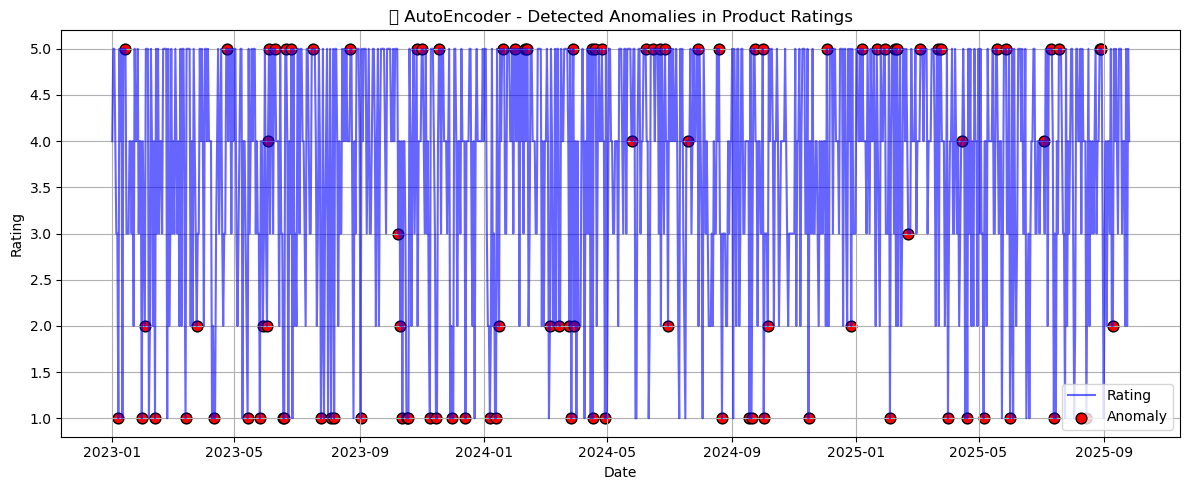

In [10]:
import matplotlib.pyplot as plt

models = {
    "KNN": 'knn_anomaly',
    "Isolation Forest": 'iforest_anomaly',
    "AutoEncoder": 'autoencoder_anomaly'
}

for name, col in models.items():
    plt.figure(figsize=(12, 5))
    plt.plot(df['timestamp'], df['rating'], label='Rating', color='blue', alpha=0.6)
    plt.scatter(df['timestamp'][df[col] == 1], df['rating'][df[col] == 1],
                color='red', label='Anomaly', s=60, edgecolors='k')
    plt.title(f'🛒 {name} - Detected Anomalies in Product Ratings')
    plt.xlabel("Date")
    plt.ylabel("Rating")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 💾 **6. Export Anomalies for Review**

In [11]:
# Combine all anomalies
df['any_model_flagged'] = df[['knn_anomaly', 'iforest_anomaly', 'autoencoder_anomaly']].any(axis=1).astype(int)

# Extract and save
anomalies = df[df['any_model_flagged'] == 1]
anomalies.to_csv("detected_review_anomalies.csv", index=False)

print(f"💡 Total anomalies detected by any model: {len(anomalies)}")

💡 Total anomalies detected by any model: 162


### 🧪 **7. Test a model on New Data **

In [12]:
# Example test data: Let's say this is an anomalous product review
test_data = pd.DataFrame({
    'rating': [3],  # Example rating
    'review_length': [200],  # Example review length (in characters)
    'sentiment_score': [0.1]  # Example sentiment score
})

# Preprocess the test data: standardize it using the scaler fitted on the training data
test_data_scaled = scaler.transform(test_data)


# Use the trained models to predict if the test data is an anomaly
knn_anomaly = knn_model.predict(test_data_scaled)[0]  # KNN anomaly prediction
iforest_anomaly = iforest_model.predict(test_data_scaled)[0]  # Isolation Forest anomaly prediction
autoencoder_anomaly = autoencoder_model.predict(test_data_scaled)[0]  # AutoEncoder anomaly prediction

# Print the results
print("KNN Anomaly Prediction: ", knn_anomaly)
print("Isolation Forest Anomaly Prediction: ", iforest_anomaly)
print("AutoEncoder Anomaly Prediction: ", autoencoder_anomaly)


KNN Anomaly Prediction:  1
Isolation Forest Anomaly Prediction:  0
AutoEncoder Anomaly Prediction:  1


In [13]:
# Combine models into an ensemble approach
def ensemble_predict(models, X):
    predictions = [model.predict(X) for model in models]
    
    # Majority voting: if at least half of the models flag as anomalous, mark as anomaly
    majority_vote = np.mean(predictions, axis=0) > 0.5
    return majority_vote.astype(int)

# Models list
models = [knn_model, iforest_model, autoencoder_model]

# Create test data
test_data = pd.DataFrame({
    'rating': [3],  
    'review_length': [200],  
    'sentiment_score': [0.1]  
})

# Standardize the test data
test_data_scaled = scaler.transform(test_data)

# Get ensemble prediction
ensemble_anomaly = ensemble_predict(models, test_data_scaled)

print("Ensemble Anomaly Prediction: ", ensemble_anomaly[0])


Ensemble Anomaly Prediction:  1


### ✅ **Summary**

This full demo shows how to:
- Build synthetic review data with injected anomalies
- Train multiple anomaly detection models using **PyOD**
- Evaluate each model's performance
- Visualize and export detected anomalies



pip install torch torchvision torchaudio
